<a href="https://colab.research.google.com/github/sarthak-314/100-Days-in-Data/blob/master/5.%20Data%20Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DATA PREPROCESSING**
***

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.5)

DF_PATH = './100D Data/Final Dataframes'
%cd /content/drive/My\ Drive

In [ ]:
df_code = pd.read_csv(os.path.join(DF_PATH, 'df_code'))
df_smartwatch = pd.read_csv(os.path.join(DF_PATH, 'df_smartwatch'))
df_date = pd.read_csv(os.path.join(DF_PATH, 'df_date'))

I want to predict the total coding time for a particular day given some features of the day. 

## **Feature Selection**
Selecting the features that are most correlated with total coding time

In [ ]:
grouped_df = df_code.groupby('date')['duration(hr)'].sum().reset_index()
df = grouped_df.merge(df_smartwatch, on='date')
df = df.rename({'duration(hr)' : 'total_code_time'}, axis=1)
df.head(3)

,date,total_code_time,sleep,deep_sleep,sleep_start,wakeup_time,sleep_duration(hr),steps_walked,km_walked,avg_heart_rate,stress,calories,week
0,1st September,7.25,9:21 PM - 4:47 AM,72,9:21 PM,4:47 AM,7.43,7101,6.02,58,43,2670,2
1,23rd August,7.25,7:54 PM - 4:50 AM,48,7:54 PM,4:50 AM,8.93,6893,5.40,54,40,3133,1
2,24th August,9.25,5:55 PM - 12:23 AM,48,5:55 PM,12:23 AM,6.47,17430,14.62,55,38,3607,1


Let's see how the features are correlated

Total code time shows highest correlation with the features :  ['stress', 'avg_heart_rate', 'steps_walked', 'km_walked', 'calories', 'deep_sleep']




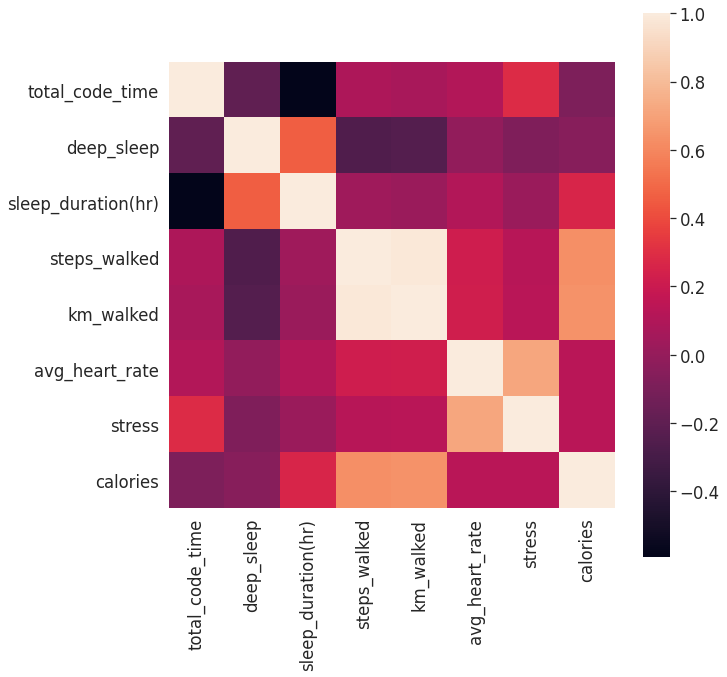

In [ ]:
plt.figure(figsize=(10, 10))
correlation = df.drop('week', axis=1).corr()
sns.heatmap(correlation, square=True)
columns = correlation.nlargest(7, 'total_code_time').index
print('Total code time shows highest correlation with the features : \x1b[32m', columns.to_list()[1:])
print('\n')

We only know deep sleep and total sleep duration for the day before it starts. **Deep sleep is a better predictor for total code time than total sleep duration** so I will take deep sleep as feature #1

**Dividing each week into - weekstart, weekmid and weekend**

Instead of 7 categories - Sunday, Monday.. etc, I only take 3 categories

In [ ]:
def get_weekday(x):
    days = x['days_after_break']
    weekdays = x['days_in_week']
    if days <= weekdays/3: return 'weekstart'
    if days <= 2*weekdays/3: return 'weekmid'
    else: return 'weekend'

df_date['days_in_week'] = df_date.week.apply(lambda x : df_date.groupby('week')['date'].count()[x])
df_date['weekday'] = df_date.apply(get_weekday, axis=1)
df_date.drop('days_in_week', axis=1, inplace=True)
df_date.head()

,date,day_number,is_halfday,days_after_break,week,weekday
0,23rd August,0.0,False,1,1,weekstart
1,24th August,1.0,False,2,1,weekstart
2,25th August,2.0,False,3,1,weekmid
3,26th August,3.0,False,4,1,weekmid
4,27th August,4.0,False,5,1,weekend


Merging df with df_date

In [ ]:
df.day_number.dtype

dtype('float64')

In [ ]:
df = df.merge(df_date[['date', 'weekday', 'day_number']], on='date')
df = df.sort_values(by=['day_number'])
df.head()

,date,total_code_time,sleep,deep_sleep,sleep_start,wakeup_time,sleep_duration(hr),steps_walked,km_walked,avg_heart_rate,stress,calories,week,weekday,day_number
1,23rd August,7.25,7:54 PM - 4:50 AM,48,7:54 PM,4:50 AM,8.93,6893,5.40,54,40,3133,1,weekstart,0.0
2,24th August,9.25,5:55 PM - 12:23 AM,48,5:55 PM,12:23 AM,6.47,17430,14.62,55,38,3607,1,weekstart,1.0
3,25th August,5.50,9:59 PM - 5:48 AM,77,9:59 PM,5:48 AM,7.82,7339,5.94,51,22,2670,1,weekmid,2.0
4,26th August,9.00,7:53 PM - 12:53 AM,48,7:53 PM,12:53 AM,5.00,4195,3.55,51,33,2634,1,weekmid,3.0
5,27th August,6.75,8:38 PM - 1:38 AM,10,8:38 PM,1:38 AM,5.00,6110,4.93,50,17,2697,1,weekend,4.0


On wakeup time

In [ ]:
def get_wakeup_at_hr(wakeup_time):
    time = wakeup_time.split(' ')[0]
    hour, minute = time.split(':')
    wakeup_at_hr = round(int(hour) + float(minute) / 60, 3)
    return wakeup_at_hr

df['wakeup_at_hr'] = df.wakeup_time.apply(get_wakeup_at_hr)

In [ ]:
df.head()

,date,total_code_time,sleep,deep_sleep,sleep_start,wakeup_time,sleep_duration(hr),steps_walked,km_walked,avg_heart_rate,stress,calories,week,weekday,day_number,wakeup_at_hr
1,23rd August,7.25,7:54 PM - 4:50 AM,48,7:54 PM,4:50 AM,8.93,6893,5.40,54,40,3133,1,weekstart,0.0,4.833
2,24th August,9.25,5:55 PM - 12:23 AM,48,5:55 PM,12:23 AM,6.47,17430,14.62,55,38,3607,1,weekstart,1.0,12.383
3,25th August,5.50,9:59 PM - 5:48 AM,77,9:59 PM,5:48 AM,7.82,7339,5.94,51,22,2670,1,weekmid,2.0,5.800
4,26th August,9.00,7:53 PM - 12:53 AM,48,7:53 PM,12:53 AM,5.00,4195,3.55,51,33,2634,1,weekmid,3.0,12.883
5,27th August,6.75,8:38 PM - 1:38 AM,10,8:38 PM,1:38 AM,5.00,6110,4.93,50,17,2697,1,weekend,4.0,1.633


In [ ]:
df[['total_code_time', 'wakeup_at_hr']].corr()

,total_code_time,wakeup_at_hr
total_code_time,1.000000,0.247264
wakeup_at_hr,0.247264,1.000000


total_code_time and wakeup_hr are highly correlated so I might take wakeup_hr as a feature in the future

In [ ]:
#TODO: Drop outliers
X = df[['deep_sleep', 'wakeup_at_hr', 'weekday', 'date']]
Y = df[['total_code_time', 'date']]

# setting date as index column 
X.set_index('date', inplace=True) 
Y.set_index('date', inplace=True)

#TODO: Sort the date values before stacking the shit
X.head()

,deep_sleep,wakeup_at_hr,weekday
date,,,
23rd August,48,4.833,weekstart
24th August,48,12.383,weekstart
25th August,77,5.800,weekmid
26th August,48,12.883,weekmid
27th August,10,1.633,weekend


I will One Hot Encode manually because it's more straightforward

In [ ]:
#One Hot Encoding
X['is_weekstart'] = (X.weekday == 'weekstart').astype(int)
X['is_weekmid'] = (X.weekday == 'weekmid').astype(int)
X['is_weekend'] = (X.weekday == 'weekend').astype(int)

X = X.drop('weekday', axis=1)

In [ ]:
X.head()

,deep_sleep,wakeup_at_hr,is_weekstart,is_weekmid,is_weekend
date,,,,,
23rd August,48,4.833,1,0.0,0.0
24th August,48,12.383,1,0.0,0.0
25th August,77,5.800,0,1.0,0.0
26th August,48,12.883,0,1.0,0.0
27th August,10,1.633,0,0.0,1.0


In [ ]:
Y.head()

,total_code_time
date,
1st September,7.25
23rd August,7.25
24th August,9.25
25th August,5.50
26th August,9.00


In [ ]:
SAVE_PATH = './100D Data/Model Data'
X.to_csv(os.path.join(SAVE_PATH, 'X'))
Y.to_csv(os.path.join(SAVE_PATH, 'Y'))

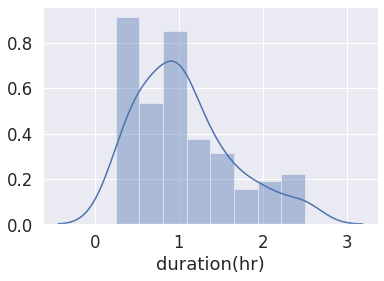

In [ ]:
#TODO : Add this in exploration
sns.distplot(df_code['duration(hr)'])


 mu = 1.06 and sigma = 0.57



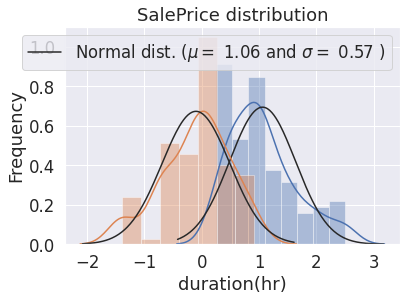

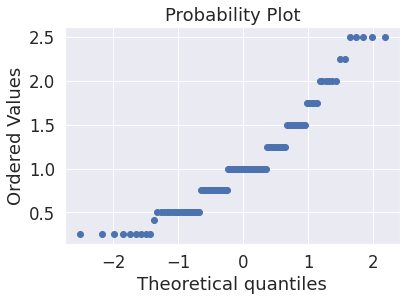

In [ ]:
#TODO: Why normal distribution/
from scipy import stats
import numpy as np
from scipy.stats import norm, skew #for some statistics
sns.distplot(df_code['duration(hr)'] , fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_code['duration(hr)'].dropna())
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_code['duration(hr)'], plot=plt)
plt.show()

In [ ]:
#TODO: Do log transformation of shit if fucked
#TODO: Box cox transformation of highly skewed features
#TODO: Make Model Superior (after getting eveything done) based on kaggle notebook - stacked regressoin model

In [ ]:
color = sns.color_palette()

In [ ]:
numeric_feats = df_smartwatch.dtypes[df_smartwatch.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = df_smartwatch[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
steps_walked,1.682016
km_walked,1.619765
calories,1.293588
avg_heart_rate,0.912538
week,0.320867
deep_sleep,0.095960
stress,-0.234459
sleep_duration(hr),-0.294812


My final features for predicting total coding time are deep_sleep and day_of_week